In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import os
import scipy.signal
import scipy.stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
%matplotlib inline


In [2]:
def build_model(X_train,y_train, X_test, y_test):
    
    
    def objective(parameters, n_folds = 10):
        
        # fit model to the first half set
        Dtrain = xgb.DMatrix(X_train, label=y_train)
        mdl = xgb.train(parameters, Dtrain)
        
        
        Observed = np.array([])
        Forecasted = np.array([])
        

        test_set = xgb.DMatrix(X_test, label=y_test)
        y_pred = mdl.predict(test_set)

            
        loss = 100 - appliance_acc(y_test,y_pred)
        
        print('loss:',loss)
        return {'loss': loss, 'parameters': parameters, 'status': STATUS_OK}


    # Define the space to search for best hyperparameters
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 2),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'objective': 'reg:linear',
        'eval_metric':'mae',
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed':315469
    }
    


    trials = Trials()
    
    best = fmin(fn = objective, space = space,algo = tpe.suggest,trials = trials,max_evals = 30,verbose=0)
    best_trial = sorted(trials.results, key = lambda x: x['loss'])
    params = best_trial[0]['parameters']
    
    Dtrain = xgb.DMatrix(X_train, label=y_train)
    best_bayes_model = xgb.train(params,Dtrain)
    
    test_set = xgb.DMatrix(X_test, label=y_test)
    y_pred = best_bayes_model.predict(test_set)
    xgb_acc = 100-best_trial[0]['loss']

    

#     print('Best acc:',xgb_acc)
#     mdl = best_bayes_model
        
    
    return xgb_acc,y_pred

In [3]:
def window(a, w , o , copy = False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def appliance_acc(y_true,y_pred):
    acc = 1-(np.sum(np.abs(y_true-y_pred))/(2*np.sum(np.abs(y_true))))
    acc = acc*100
    return acc


In [4]:
df = pd.read_csv('stelioslog.txt',sep = '/', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5
0,meas,124B0011EEEA47,124B0002CC92AC,curA,10,1589534054 0.0192860756069
1,meas,124B0011EEEA47,124B0002CC92AC,rpwrA,10,1589534054 -4.14318466187
2,meas,124B0011EEEA47,124B0002CC92AC,cnrgA,10,1589534054 14.366
3,meas,124B0011EEEA47,124B0002CC92AC,pnrgA,10,1589534054 0.0
4,meas,124B0011EEEA47,124B0002CC92AC,rsumA,10,1589534054 0.0


In [6]:
df = df.iloc[:1000000]

In [7]:
df[[5,6]] = df[5].str.split(' ', expand=True)
df = df.drop([0,1,4], axis=1)

df.columns = ['devMAC','desc','ts','value']
df.head()

,devMAC,desc,ts,value
0,124B0002CC92AC,curA,1589534054,0.0192860756069
1,124B0002CC92AC,rpwrA,1589534054,-4.14318466187
2,124B0002CC92AC,cnrgA,1589534054,14.366
3,124B0002CC92AC,pnrgA,1589534054,0.0
4,124B0002CC92AC,rsumA,1589534054,0.0


In [8]:
grouped = df.groupby('devMAC')
for name, group in grouped:
    print(name)

124B0002CC7F64
124B0002CC8056
124B0002CC831B
124B0002CC8FCC
124B0002CC9086
124B0002CC92AC
124B00040A80CA
124B00040A83D4
124B00194A53E1


In [6]:
'124B0002CC8056':washing machine
'124B0002CC831B':tvset
'124B0002CC8FCC':dishwasher
'124B0002CC9086':tv2
'124B0002CC92AC':laptop
'124B00040A83D4':isogeio
'124B0002CC7F64':unknown, serial is 102.204.000001 -->101.101.000101
'124B00040A80CA':central meter, 102.201.000492
'124B00194A53E1':heat pump

SyntaxError: invalid syntax (<ipython-input-6-cd10c4d12dae>, line 1)

In [36]:
df1 = grouped.get_group('124B00040A80CA')
df1.drop('devMAC',inplace=True, axis=1)
df1.reset_index(inplace=True, drop=True)
df1

,desc,ts,value
0,rpwrA,1589534055,111.324150085
1,rpwrB,1589534055,197.658966064
2,rpwrC,1589534055,-136.717010498
3,cosA,1589534055,0.943214297295
4,cosB,1589534055,0.706749677658
...,...,...,...
333236,rpwrB,1589585647,196.955032349
333237,rpwrC,1589585647,-100.712745667
333238,cosA,1589585647,0.960191428661
333239,cosB,1589585647,0.767729699612


In [42]:
sdesc = df1.groupby('desc')
tdf = pd.DataFrame([])

for name,group in sdesc:
#     print(name)
    if name=='pwrA':
        group.reset_index(inplace=True, drop=True)
        group.drop('desc',axis=1, inplace=True)
        group.columns = ['ts',name]

        group.set_index('ts', drop=True, inplace=True)
        group.sort_index(inplace=True)
#         print(group[15000:60000])
        tdf = pd.concat([tdf,group.iloc[:13300].reset_index(drop=True)],axis=1)
    if name=='pwrB':
        group.reset_index(inplace=True, drop=True)
        group.drop('desc',axis=1, inplace=True)
        group.columns = ['ts',name]

        group.set_index('ts', drop=True, inplace=True)
        group.sort_index(inplace=True)
    #     print(group.head())
        tdf = pd.concat([tdf,group.iloc[:13300].reset_index(drop=True)],axis=1)
    if name=='pwrC':
        group.reset_index(inplace=True, drop=True)
        group.drop('desc',axis=1, inplace=True)
        group.columns = ['ts',name]

        group.set_index('ts', drop=True, inplace=True)
        group.sort_index(inplace=True)
    #     print(group.head())
        tdf = pd.concat([tdf,group.iloc[:13300].reset_index(drop=True)],axis=1)
    


In [46]:
tmp = tdf[['pwrA','pwrB','pwrC']]
tmp.head()

,pwrA,pwrB,pwrC
0,300.445037842,200.786056519,324.852233887
1,301.424835205,200.673782349,327.893676758
2,301.355712891,201.141998291,331.529418945
3,301.355712891,201.141998291,331.529418945
4,300.471252441,202.9790802,323.800109863


In [47]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)

tmp['ts'] = tmp.index
tmp['ts'] = pd.to_datetime(tmp['ts'], unit='s')
tmp.set_index('ts',drop=True, inplace=True)
for col in tmp.columns:
    tmp[col] = tmp[col].astype(float)
# tmp['pwrA'] = tmp['pwrA'].astype('float')
tmp = tmp.resample('2S').max()
tmp = tmp.iloc[1:]

tmp['pwrtotal'] = tmp['pwrA']+tmp['pwrB']+tmp['pwrC']
sm = tmp['pwrtotal']

In [48]:
sm = tmp['pwrtotal']
sm = sm.to_numpy()


In [49]:
# Read plug data

df1 = grouped.get_group('124B0002CC7F64')
df1.drop('devMAC',inplace=True, axis=1)
df1.reset_index(inplace=True, drop=True)

sdesc = df1.groupby('desc')
tdf = pd.DataFrame([])

for name,group in sdesc:
#     print(name)
    if name=='pwrA':
        group.reset_index(inplace=True, drop=True)
        group.drop('desc',axis=1, inplace=True)
        group.columns = ['ts',name]

        group.set_index('ts', drop=True, inplace=True)
        group.sort_index(inplace=True)
    #     print(group.head())
        tdf = pd.concat([tdf,group],axis=1)
    
    
tmp = tdf[['pwrA']]
tmp['ts'] = tmp.index
tmp['ts'] = pd.to_datetime(tmp['ts'], unit='s')
tmp.set_index('ts',drop=True, inplace=True)
for col in tmp.columns:
    tmp[col] = tmp[col].astype(float)
# tmp['pwrA'] = tmp['pwrA'].astype('float')
tmp = tmp.resample('2S').max()
tmp = tmp.iloc[1:]

plg = tmp['pwrA']
plg = plg.to_numpy()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df1 = grouped.get_group('124B0002CC7F64')
df1.drop('devMAC',inplace=True, axis=1)
df1.reset_index(inplace=True, drop=True)

sdesc = df1.groupby('desc')
tdf = pd.DataFrame([])

for name,group in sdesc:
#     print(name)
    if name=='pwrA':
        group.reset_index(inplace=True, drop=True)
        group.drop('desc',axis=1, inplace=True)
        group.columns = ['ts',name]

        group.set_index('ts', drop=True, inplace=True)
        group.sort_index(inplace=True)
    #     print(group.head())
        tdf = pd.concat([tdf,group],axis=1)
    
    
tmp = tdf[['pwrA']]
tmp['ts'] = tmp.index
tmp['ts'] = pd.to_datetime(tmp['ts'], unit='s')
tmp.set_index('ts',drop=True, inplace=True)
for col in tmp.columns:
    tmp[col] = tmp[col].astype(float)
# tmp['pwrA'] = tmp['pwrA'].astype('float')
tmp = tmp.resample('1S').max()
tmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,pwrA
ts,
2020-05-15 09:14:15,148.811539
2020-05-15 09:14:16,NaN
2020-05-15 09:14:17,148.926773
2020-05-15 09:14:18,149.399353
2020-05-15 09:14:19,NaN
...,...
2020-05-15 23:34:04,1.988729
2020-05-15 23:34:05,NaN
2020-05-15 23:34:06,1.969308


In [50]:
meter = window(sm, 10,5)
plug = window(plg,10,5)

In [51]:
# Extract features
print('plug size:',len(plug))


Y = np.array([])
X = np.empty((0,9))

# mean,min,max,median,rms,perc25,perc75,std,energy
for i in range(0,len(plug)):
    print(i)
    Y = np.append(Y,np.mean(plug[i,:]))
    X = np.append(X,np.array([[np.mean(meter[i,:]),np.min(meter[i,:]),np.max(meter[i,:]),\
            np.median(meter[i,:]),np.sqrt(np.mean(meter[i,:]**2, axis=None)),\
            np.percentile(meter[i,:],25),np.percentile(meter[i,:],75),np.std(meter[i,:]),\
                                    np.sum(meter[i,:])]]),axis = 0)

plug size: 5158
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
27

IndexError: index 1328 is out of bounds for axis 0 with size 1328

In [42]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle = False)
print('trainX size:',trainX.shape)
print('trainY size:',trainY.shape)
acc,y_pred = build_model(trainX,trainY, testX, testY)

trainX size: (69, 9)
trainY size: (69,)
loss:                                               
7.434613085299489                                   
loss:                                                                       
13.174035523800725                                                          
loss:                                                                       
1.1965330987105744                                                          
loss:                                                                       
0.29335390501633185                                                          
loss:                                                                         
1.8353725227745628                                                            
loss:                                                                         
2.697174162349043                                                             
loss:                                                                      

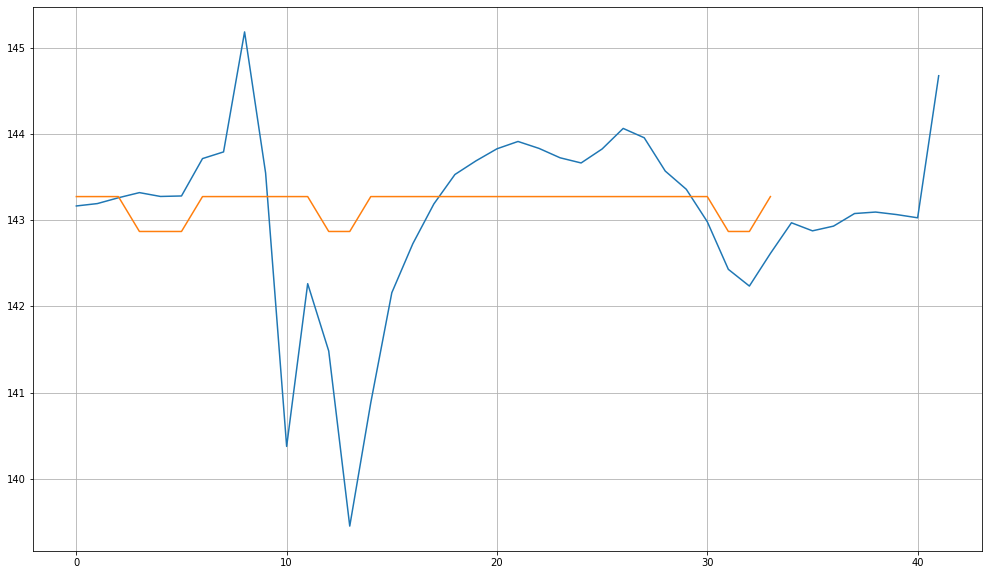

In [45]:
fig = plt.figure(figsize = [17,10])
plt.grid(True)
plt.plot(testY)
plt.plot(y_pred)

In [51]:
acc = appliance_acc(testY[:34],y_pred)
print('Accuracy:',acc)

Accuracy: 99.7411840579643


In [50]:
len(testY)

42